In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
# image_path = "E:\\Thesis\\rvl-cdip\\images\\imagesa\\a\\a\\a\\aaa06d00\\50486482-6482.tif"
image_path = "dataset/val/forged/0000942310_forged.png"

# --- 3. Read the image ---
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert for plotting

# --- 4. Convert to grayscale ---
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# --- 5. Apply Gaussian blur (optional, helps noise reduction) ---
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# --- Dynamic thresholds using median ---
median_val = np.median(blurred)
sigma = 0.2  # tweak sensitivity (0.2–0.4)
lower = int(max(0, (1.0 - sigma) * median_val))
upper = int(min(255, (1.0 + sigma) * median_val))

In [3]:
def auto_threshold_params(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute brightness and contrast
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)
    binary_thresh = mean_intensity + 0.5 * std_intensity

    # Noise estimation via Laplacian variance
    noise_level = cv2.Laplacian(gray, cv2.CV_64F).var()

    # Dynamic Canny thresholds based on noise
    if noise_level > 300:
        edge_thresh1, edge_thresh2 = 60, 180
    elif noise_level > 150:
        edge_thresh1, edge_thresh2 = 40, 120
    else:
        edge_thresh1, edge_thresh2 = 25, 80

    # Dynamic contour area threshold (relative to resolution)
    height, width = gray.shape
    area_filter_min = (height * width) * 0.0001  # 0.01% of total area

    return {
        "binary_thresh": int(binary_thresh),
        "edge_thresh1": edge_thresh1,
        "edge_thresh2": edge_thresh2,
        "area_filter_min": area_filter_min,
        "noise_level": noise_level,
        "mean_intensity": mean_intensity,
        "std_intensity": std_intensity
    }

In [4]:
def detect_potential_regions(image):
    # Step 1: Compute adaptive parameters
    params = auto_threshold_params(image)

    print(f"Brightness: {params['mean_intensity']:.2f}, Contrast: {params['std_intensity']:.2f}")
    print(f"Noise: {params['noise_level']:.2f}")
    print(f"Dynamic thresholds -> Canny: ({params['edge_thresh1']}, {params['edge_thresh2']}), "
          f"Binary: {params['binary_thresh']}, Min area: {params['area_filter_min']:.1f}")

    # Step 2: Preprocess
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, params['edge_thresh1'], params['edge_thresh2'])

    # Step 3: Threshold & contour detection
    _, binary = cv2.threshold(gray, params['binary_thresh'], 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 4: Highlight potential forged regions
    output = image.copy()
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > params['area_filter_min']:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(output, (x, y), (x+w, y+h), (0, 0, 255), 2)

    return output, params

Brightness: 240.12, Contrast: 42.46
Noise: 4083.42
Dynamic thresholds -> Canny: (60, 180), Binary: 261, Min area: 76.2


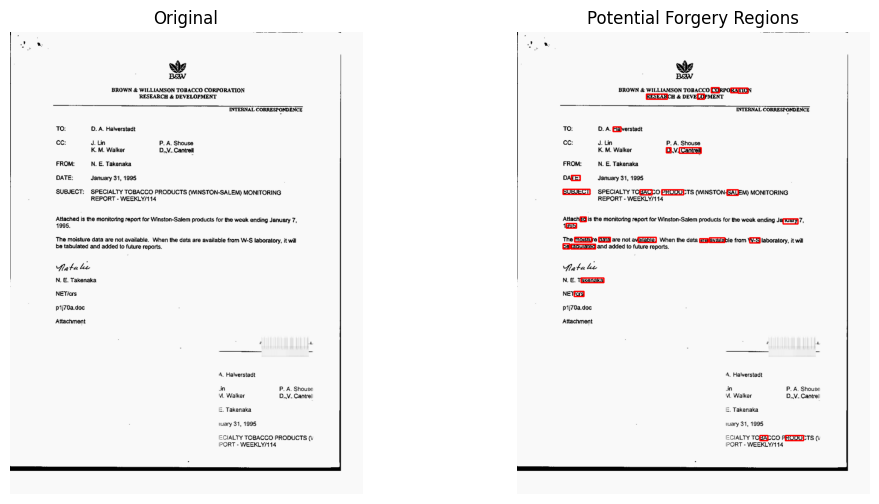

In [5]:
forgery_map, params = detect_potential_regions(image)

# Display results
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Potential Forgery Regions")
plt.imshow(cv2.cvtColor(forgery_map, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()